# Heart Failure — Baseline Setup & Data Audit

Building a transparent, reproducible baseline to predict `HeartDisease`.

**Data**
- 'heart.csv'

In [49]:
# --- Reproducible environment & lightweight utilities ---
from __future__ import annotations

import os
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# --- Training utilities ---
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, classification_report
)
from tqdm.auto import tqdm
import math
import os

# Plot defaults: consistent sizing and readable grids
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 140

# Keep the console clean from non-critical warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Project paths
DATASET_PATH = "../data/heart.csv"
MODEL_PATH = "../models"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


## Load raw data & quick inspection
Loading the dataset from `../data/`, previewing rows, and checking dtypes/nulls.
This confirms file access, column names, and highlights obvious data issues before defining any schema.

In [2]:
# load dataset
df = pd.read_csv(DATASET_PATH)

In [3]:
# Shapes and a quick peek
print(f"dataset shape: {df.shape}")
display(df.head(5))

# Structural info (dtypes + non-null counts)
df.info()

# ─────────────────────────────────────────────────────
# Missing values and descriptive statistics
# ─────────────────────────────────────────────────────
# Missing per column (training)
display(df.isna().sum().to_frame("missing").T)

# Numeric descriptives
display(df.describe(include=[np.number]).T)

dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
missing,0,0,0,0,0,0,0,0,0,0,0,0


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [4]:
from sklearn.model_selection import train_test_split

TARGET = 'HeartDisease'
# Ratios 
TEST_SIZE = 0.15
VAL_SIZE  = 0.15   # of the remaining after test split

In [5]:
# Train/Test split
df_train, df_test = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df[TARGET], # keep (approx.) the same class proportions in each split
    random_state=RNG_SEED,
)

# Train/Val split
df_train, df_val = train_test_split(
    df_train,
    test_size=VAL_SIZE,
    stratify=df_train[TARGET], # keep (approx.) the same class proportions in each split
    random_state=RNG_SEED,
)

In [6]:
def _balance(y):
    vc = y.value_counts().sort_index()
    n = int(vc.sum())
    return {int(k): f"{int(v)} ({100*v/n:.2f}%)" for k, v in vc.items()}

print("Shapes:")
print("  train:", df_train.shape)
print("  val  :", df_val.shape)
print("  test :", df_test.shape)

print("\nTarget balance:")
print("  train:", _balance(df_train[TARGET]))
print("  val  :", _balance(df_val[TARGET]))
print("  test :", _balance(df_test[TARGET]))

Shapes:
  train: (663, 12)
  val  : (117, 12)
  test : (138, 12)

Target balance:
  train: {0: '296 (44.65%)', 1: '367 (55.35%)'}
  val  : {0: '52 (44.44%)', 1: '65 (55.56%)'}
  test : {0: '62 (44.93%)', 1: '76 (55.07%)'}


In [7]:
def plot(df):
    # Copy dataset to avoid modifying the original
    plot_df = df.copy()

    # Define numeric columns (all except target handled similarly)
    cols = plot_df.columns

    # Plot style
    sns.set_theme(style="whitegrid")
    plt.rcParams["figure.dpi"] = 140

    # Grid layout
    n_cols = 2
    n_rows = len(cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))

    for i, col in enumerate(cols):
        ax_hist = axes[i, 0]
        ax_box  = axes[i, 1]

        data = plot_df[col].dropna()

        # Histogram
        sns.histplot(data, bins=50, kde=True, ax=ax_hist, color="skyblue", edgecolor=None)
        ax_hist.set_title(f"Distribution — {col}")
        ax_hist.set_xlabel("")
        ax_hist.set_ylabel("count")

        # Boxplot
        sns.boxplot(x=data, ax=ax_box, color="lightcoral", orient="h")
        ax_box.set_title(f"Boxplot — {col}")
        ax_box.set_xlabel(col)

    plt.tight_layout(h_pad=1.5)
    plt.show()

In [ ]:
# One-hot encoding categorical features and mapping 'Sex' to 0/1 since it's already binary
categorical_features = ["ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_features = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
target_col = "HeartDisease"

# Map 'Sex' column to binary values (M → 1, F → 0) across all splits
# This column is binary, so it doesn’t need one-hot encoding
for df in (df_train, df_val, df_test):
    df["Sex"] = df["Sex"].map({"M": 1, "F": 0})

# Initialize the OneHotEncoder and fit it ONLY on the training set
# 'sparse=False' returns a dense NumPy array instead of a sparse matrix
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(df_train[categorical_features])

# applies the trained encoder to any dataframe
def apply_encoding(df):
    # Transform the categorical columns using the same fitted encoder
    # ohe_array contains only the new columns 
    ohe_array = encoder.transform(df[categorical_features])
    
    # Convert the encoded array back into a dataFrame
    ohe_df = pd.DataFrame(
        ohe_array,
        index=df.index,
        columns=encoder.get_feature_names_out(categorical_features)
    )

    # Build the new dataframe by combining:
    # - numeric features
    # - binary 'Sex' column
    # - encoded categorical features
    new_df = pd.concat(
        [
            df[numeric_features + ["Sex"]].reset_index(drop=True),
            ohe_df.reset_index(drop=True),
        ],
        axis=1
    )

    # Reattach the target column 
    new_df[target_col] = df[target_col].values

    return new_df

# Apply the same transformation to train, validation, and test sets
df_train_enc = apply_encoding(df_train)
df_val_enc   = apply_encoding(df_val)
df_test_enc  = apply_encoding(df_test)

# split the encoded data into X (features) and y (target)
X_train = df_train_enc.drop(columns=[target_col])
y_train = df_train_enc[target_col]

X_val = df_val_enc.drop(columns=[target_col])
y_val = df_val_enc[target_col]

X_test = df_test_enc.drop(columns=[target_col])
y_test = df_test_enc[target_col]


In [14]:
display(X_train.shape)
display(X_train.head(5))

(663, 19)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,65,150,236,1,105,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,54,130,0,0,117,1.4,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,38,115,0,0,128,0.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,37,120,215,0,170,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,59,170,288,0,159,0.2,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
display(y_train.shape)
display(y_train.head(5))

(663,)

0    1
1    1
2    1
3    0
4    1
Name: HeartDisease, dtype: int64

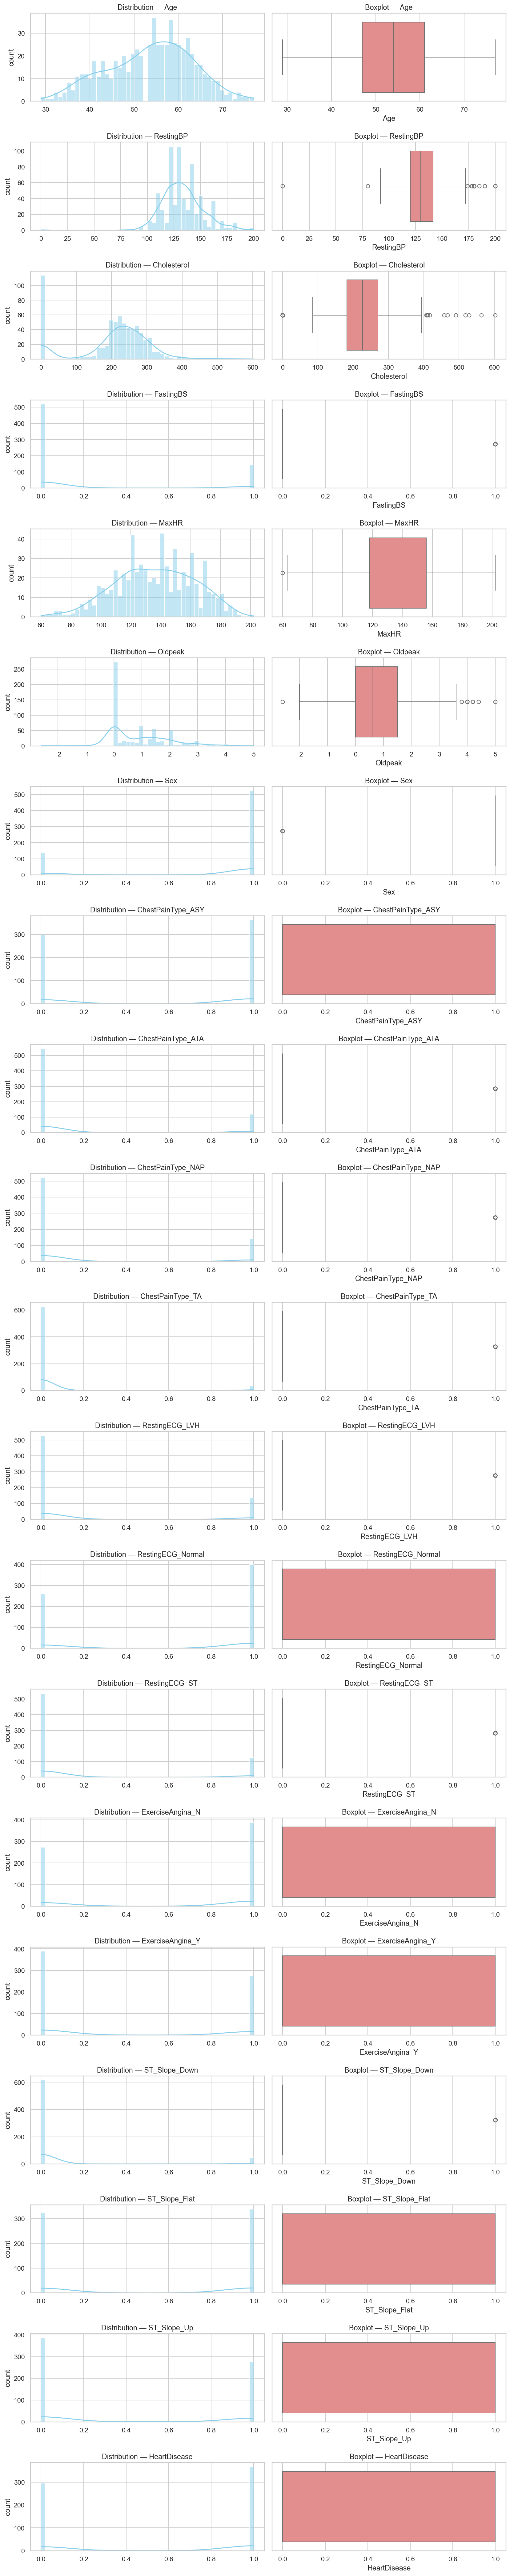

In [ ]:
plot(df_train_enc)

In [ ]:
# =========================
# Custom transformers
# =========================
class QuantileClipper(BaseEstimator, TransformerMixin):
    """
    Per-column winsorization: clip to [q_low, q_high] learned from training data.
    Useful for heavy-tailed continuous features.
    """
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.q_low_ = np.nanquantile(X, self.low, axis=0)
        self.q_high_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.q_low_, self.q_high_)


class ValueClipper(BaseEstimator, TransformerMixin):
    """
    Clip all values to fixed [min_val, max_val].
    Used for variables with known plausible ranges (e.g. Age, Oldpeak >= 0).
    """
    def __init__(self, min_val=None, max_val=None):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        if self.min_val is not None:
            X = np.maximum(X, self.min_val)
        if self.max_val is not None:
            X = np.minimum(X, self.max_val)
        return X


class ZeroAsMedianImputer(BaseEstimator, TransformerMixin):
    """
    Replace 0 values with the median of NON-zero values (per column),
    for features where 0 is physiologically impossible and actually means 'missing'.

    Designed here for the Cholesterol column.
    """
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        medians = []
        for j in range(X.shape[1]):
            col = X[:, j]
            non_zero = col[col != 0]
            if non_zero.size > 0:
                medians.append(float(np.median(non_zero)))
            else:
                # Fallback: if everything is zero, use nanmedian of the column
                medians.append(float(np.nanmedian(col)))
        self.medians_ = np.array(medians)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = X.copy()
        for j in range(X.shape[1]):
            zero_mask = X[:, j] == 0
            if np.any(zero_mask):
                X[zero_mask, j] = self.medians_[j]
        return X
# =========================
# Column groups 
# =========================
ALL_FEATURES = list(X_train.columns)

AGE_COL = ["Age"]
RESTINGBP_COL = ["RestingBP"]
CHOL_COL = ["Cholesterol"]
MAXHR_COL = ["MaxHR"]
OLDPEAK_COL = ["Oldpeak"]

NUMERIC_BASE = set(AGE_COL + RESTINGBP_COL + CHOL_COL + MAXHR_COL + OLDPEAK_COL)

# everything else in X is already binary / one-hot
BINARY_OHE_COLS = [c for c in ALL_FEATURES if c not in NUMERIC_BASE]


# =========================
# Pipelines for each block
# =========================

# Age: clean, mild spread; just clip to plausible bounds + robust scale
age_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),        # safety net
    ("clip", ValueClipper(min_val=28, max_val=80)),       # based on data + plausibility
    ("scaler", RobustScaler()),
])

# RestingBP: median impute + winsorize + robust scale
restingbp_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", QuantileClipper(low=0.01, high=0.99)),
    ("scaler", RobustScaler()),
])

# Cholesterol: 0 -> median(non-zero on train) + median impute + winsorize + log1p + robust scale
chol_pipe = Pipeline(steps=[
    ("zero_to_median", ZeroAsMedianImputer()),
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", QuantileClipper(low=0.01, high=0.99)),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler()),
])

# MaxHR: light-tailed but we keep it consistent: impute + winsor + robust scale
maxhr_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", QuantileClipper(low=0.01, high=0.99)),
    ("scaler", RobustScaler()),
])

# Oldpeak: skewed with some weird low values -> clip to >=0, winsorize, log1p, robust scale
oldpeak_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("nonneg_clip", ValueClipper(min_val=0.0)),
    ("winsor", QuantileClipper(low=0.01, high=0.99)),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler()),
])

# =========================
# Main ColumnTransformer
# =========================

preprocess = ColumnTransformer(
    transformers=[
        ("age", age_pipe, AGE_COL),
        ("restingbp", restingbp_pipe, RESTINGBP_COL),
        ("chol", chol_pipe, CHOL_COL),
        ("maxhr", maxhr_pipe, MAXHR_COL),
        ("oldpeak", oldpeak_pipe, OLDPEAK_COL),
        ("binary", "passthrough", BINARY_OHE_COLS),  # one-hot + binary features stay as 0/1
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)
# =========================
# Fit on train, apply to all splits
# =========================
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)
X_test_t = preprocess.transform(X_test)

print("Transformed shapes:",
      X_train_t.shape, X_val_t.shape, X_test_t.shape)

Transformed shapes: (663, 19) (117, 19) (138, 19)


## PyTorch data pipeline: tensors, `Dataset`, and `DataLoader`

- Convert transformed NumPy arrays to PyTorch tensors (`float32` for features, `int64` for labels).
- Wrap them in a minimal `Dataset` for tabular data.
- Create `DataLoader`s:
  - `shuffle=True` only for training.
  - A reasonable `batch_size` for stable updates.

In [60]:
X_train_t = X_train_t.astype(np.float32)
X_val_t   = X_val_t.astype(np.float32)
X_test_t  = X_test_t.astype(np.float32)

y_train = y_train.astype(np.int64).values
y_val   = y_val.astype(np.int64).values
y_test  = y_test.astype(np.int64).values

class TabularDataset(Dataset):
    """Thin dataset wrapper for numeric tabular data."""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)  # [N, D] float32
        self.y = torch.from_numpy(y)  # [N]    int64

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Instantiate datasets
train_ds = TabularDataset(X_train_t, y_train)
val_ds   = TabularDataset(X_val_t,   y_val)
test_ds  = TabularDataset(X_test_t,  y_test)

# DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Sanity check: fetch one batch
xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape, "| dtypes:", xb.dtype, yb.dtype)

Batch shapes: torch.Size([64, 19]) torch.Size([64]) | dtypes: torch.float32 torch.int64


## Model & training setup

- Device selection (`cuda` if available).
- MLP for tabular data with BatchNorm and Dropout.
- Binary loss: `CrossEntropyLoss`
- Optimizer: `AdamW`.
A quick forward pass on one batch to confirm shapes and loss.

In [74]:
device = DEVICE
# ---- Model ----
INPUT_DIM = X_train_t.shape[1]  # 12 after preprocessing (features) 
HIDDEN = [64, 32, 16, 16]               # can tune later
DROPOUT = 0.3

class TabularMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: list[int], dropout: float = 0.2):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden # dims is a list containing the number of neurons of each layer that we will chain together.
        for i in range(len(dims) - 1): # 0 -> (len(dims) - 1) 
            layers += [
                nn.Linear(dims[i], dims[i+1]), # dense connection (linear combination of inputs)
                nn.BatchNorm1d(dims[i+1]),     # normalizes activations (improves stability)
                nn.GELU(),                     # non-linearity
                nn.Dropout(dropout),           # randomly drops neurons (regularization to prevent overfitting)
            ]
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(hidden[-1] if hidden else in_dim, 1)  # binary logit
        # careful weight initialization
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m: nn.Module):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(self.backbone) > 0:
            x = self.backbone(x)
        logit = self.head(x)  # shape [B, 1]
        return logit

model = TabularMLP(INPUT_DIM, HIDDEN, DROPOUT).to(device)

# ---- Loss ----
criterion = nn.BCEWithLogitsLoss()

# ---- Optimizer ----
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [75]:
# ---- Quick sanity forward (no training yet) ----
model.eval()
with torch.no_grad():
    xb, yb = next(iter(train_loader))           # one batch from DataLoader
    xb = xb.to(device)                          # [B, 12] float32
    yb = yb.to(device).float().unsqueeze(1)     # [B, 1] float32 (for BCEWithLogits)
    logits = model(xb)                          # [B, 1]
    loss = criterion(logits, yb)
    probs = torch.sigmoid(logits)               # convert to probabilities for inspection

print(f"Batch: xb={tuple(xb.shape)}, logits={tuple(logits.shape)}, loss={loss.item():.4f}")
print(f"Probs range: min={probs.min().item():.4f}, max={probs.max().item():.4f}")

Batch: xb=(64, 19), logits=(64, 1), loss=0.6705
Probs range: min=0.3032, max=0.7830


## Training loop (with validation, early stopping, and progress bar)

**Plan**
1. Train for `EPOCHS` with mini-batches from `train_loader`.
2. After each epoch, evaluate on `val_loader`.
3. Track the best `val_auc`; save the model when it improves.
4. Stop early if no improvement for `PATIENCE` epochs.
5. Use `BCEWithLogitsLoss.
6. Show a progress bar over batches for each epoch.

**Metrics**
- `loss` on train/val.
- `ROC-AUC` (+ `Average Precision`) on validation.

**Outputs**
- Prints epoch metrics.
- Saves best weights to `../models/tabular_mlp.pt`.

In [76]:
# Speed-ups tailored to GPU/CPU
USE_AMP = torch.cuda.is_available()               # mixed precision on GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True         # auto-tune best kernels for shapes
    torch.set_float32_matmul_precision("high")    # faster matmul on Ada/Lovelace

# Hyperparameters
EPOCHS   = 30
PATIENCE = 5
LR       = 1e-3
WD       = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

# ----------------------------- Early Stopping -----------------------------
class EarlyStopping:
    """Stop training when the monitored metric hasn't improved for 'patience' epochs."""
    def __init__(self, patience: int = 5, mode: str = "max"):
        self.patience = patience
        self.mode = mode
        self.best = -math.inf if mode == "max" else math.inf
        self.bad_epochs = 0
        self.should_stop = False

    def step(self, value: float) -> bool:
        improved = (value > self.best) if self.mode == "max" else (value < self.best)
        if improved:
            self.best = value
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True
        return improved

# ----------------------------- Train One Epoch -----------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, use_amp=True):
    """Standard supervised training step over one full pass of 'loader'."""
    model.train()
    running_loss = 0.0
    scaler = torch.amp.GradScaler("cuda" ,enabled=use_amp)
    pbar = tqdm(loader, desc="train", leave=False)

    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)                 # [B, D]
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)  # [B, 1]

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda",enabled=use_amp):        # AMP forward/backward
            logits = model(xb)                                # [B, 1] logits
            loss = criterion(logits, yb)                      # scalar loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * xb.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# ----------------------------- Evaluate (Val/Test) -----------------------------
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Compute loss and metrics on 'loader' without gradients."""
    model.eval()
    total_loss = 0.0
    all_probs, all_targets = [], []

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)

        logits = model(xb)
        loss = criterion(logits, yb)
        probs = torch.sigmoid(logits)                         # convert logits → probabilities

        total_loss += loss.item() * xb.size(0)
        all_probs.append(probs.squeeze(1).cpu())
        all_targets.append(yb.squeeze(1).cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Metrics (robust to edge cases)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float("nan")
    try:
        ap = average_precision_score(all_targets, all_probs)
    except Exception:
        ap = float("nan")

    # Reference threshold 0.5
    preds = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_targets, preds)
    f1  = f1_score(all_targets, preds, zero_division=0)

    return {
        "loss": total_loss / len(loader.dataset),
        "auc": auc,
        "ap": ap,
        "acc": acc,
        "f1": f1,
    }

# ----------------------------- Training Loop -----------------------------
early = EarlyStopping(patience=PATIENCE, mode="max")
best_path = os.path.join(MODEL_PATH, "tabular_mlp.pt")

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, use_amp=USE_AMP)
    val_metrics = evaluate(model, val_loader, criterion, device)

    msg = (
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_metrics['loss']:.4f} | "
        f"val_auc={val_metrics['auc']:.4f} | "
        f"val_ap={val_metrics['ap']:.4f} | "
        f"val_acc={val_metrics['acc']:.4f} | "
        f"val_f1={val_metrics['f1']:.4f}"
    )
    print(msg)

    # Early stopping on validation AUC (maximize)
    if early.step(val_metrics["auc"]):
        torch.save({
            "model_state_dict": model.state_dict(),
            "input_dim": INPUT_DIM,
            "hidden": HIDDEN,
            "dropout": DROPOUT,
        }, best_path)
        print(f"✓ Saved new best to: {best_path} (val_auc={val_metrics['auc']:.4f})")

    if early.should_stop:
        print(f"Early stopping triggered (patience={PATIENCE}).")
        break

print("\nTraining finished.")


Epoch 1/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.7775 | val_loss=0.6598 | val_auc=0.6796 | val_ap=0.7550 | val_acc=0.6496 | val_f1=0.6772
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.6796)

Epoch 2/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.7628 | val_loss=0.6188 | val_auc=0.7544 | val_ap=0.8115 | val_acc=0.7009 | val_f1=0.7200
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.7544)

Epoch 3/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.6792 | val_loss=0.5889 | val_auc=0.7837 | val_ap=0.8393 | val_acc=0.7521 | val_f1=0.7717
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.7837)

Epoch 4/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.6176 | val_loss=0.5645 | val_auc=0.8068 | val_ap=0.8549 | val_acc=0.7778 | val_f1=0.7903
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8068)

Epoch 5/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.6066 | val_loss=0.5429 | val_auc=0.8269 | val_ap=0.8680 | val_acc=0.7949 | val_f1=0.8065
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8269)

Epoch 6/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.5806 | val_loss=0.5270 | val_auc=0.8402 | val_ap=0.8778 | val_acc=0.7949 | val_f1=0.8065
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8402)

Epoch 7/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.5675 | val_loss=0.5115 | val_auc=0.8530 | val_ap=0.8892 | val_acc=0.7949 | val_f1=0.8065
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8530)

Epoch 8/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.5403 | val_loss=0.5030 | val_auc=0.8586 | val_ap=0.8903 | val_acc=0.8034 | val_f1=0.8160
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8586)

Epoch 9/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.5166 | val_loss=0.4980 | val_auc=0.8618 | val_ap=0.8908 | val_acc=0.8034 | val_f1=0.8189
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8618)

Epoch 10/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.5127 | val_loss=0.4862 | val_auc=0.8639 | val_ap=0.8918 | val_acc=0.8120 | val_f1=0.8254
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8639)

Epoch 11/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4923 | val_loss=0.4699 | val_auc=0.8692 | val_ap=0.8978 | val_acc=0.8034 | val_f1=0.8189
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8692)

Epoch 12/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4613 | val_loss=0.4610 | val_auc=0.8716 | val_ap=0.8993 | val_acc=0.8205 | val_f1=0.8372
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8716)

Epoch 13/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4839 | val_loss=0.4590 | val_auc=0.8749 | val_ap=0.9010 | val_acc=0.8120 | val_f1=0.8281
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8749)

Epoch 14/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4741 | val_loss=0.4532 | val_auc=0.8781 | val_ap=0.9032 | val_acc=0.8205 | val_f1=0.8372
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8781)

Epoch 15/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4407 | val_loss=0.4403 | val_auc=0.8828 | val_ap=0.9074 | val_acc=0.8205 | val_f1=0.8372
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8828)

Epoch 16/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4461 | val_loss=0.4357 | val_auc=0.8870 | val_ap=0.9095 | val_acc=0.8205 | val_f1=0.8372
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8870)

Epoch 17/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4392 | val_loss=0.4349 | val_auc=0.8861 | val_ap=0.9080 | val_acc=0.8205 | val_f1=0.8372

Epoch 18/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4277 | val_loss=0.4268 | val_auc=0.8896 | val_ap=0.9111 | val_acc=0.8205 | val_f1=0.8372
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8896)

Epoch 19/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4178 | val_loss=0.4240 | val_auc=0.8926 | val_ap=0.9134 | val_acc=0.8291 | val_f1=0.8438
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8926)

Epoch 20/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4399 | val_loss=0.4202 | val_auc=0.8953 | val_ap=0.9140 | val_acc=0.8291 | val_f1=0.8438
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8953)

Epoch 21/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4268 | val_loss=0.4155 | val_auc=0.8964 | val_ap=0.9147 | val_acc=0.8291 | val_f1=0.8438
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8964)

Epoch 22/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4394 | val_loss=0.4089 | val_auc=0.8979 | val_ap=0.9162 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8979)

Epoch 23/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4165 | val_loss=0.4082 | val_auc=0.8979 | val_ap=0.9162 | val_acc=0.8291 | val_f1=0.8462

Epoch 24/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3973 | val_loss=0.4074 | val_auc=0.8982 | val_ap=0.9159 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.8982)

Epoch 25/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3893 | val_loss=0.4087 | val_auc=0.9003 | val_ap=0.9176 | val_acc=0.8291 | val_f1=0.8438
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9003)

Epoch 26/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3873 | val_loss=0.4098 | val_auc=0.9006 | val_ap=0.9175 | val_acc=0.8291 | val_f1=0.8438
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9006)

Epoch 27/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.4093 | val_loss=0.4059 | val_auc=0.9021 | val_ap=0.9196 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9021)

Epoch 28/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3861 | val_loss=0.4000 | val_auc=0.9041 | val_ap=0.9213 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9041)

Epoch 29/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3976 | val_loss=0.3992 | val_auc=0.9044 | val_ap=0.9206 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9044)

Epoch 30/30


train:   0%|          | 0/11 [00:00<?, ?it/s]

train_loss=0.3907 | val_loss=0.3993 | val_auc=0.9065 | val_ap=0.9218 | val_acc=0.8376 | val_f1=0.8527
✓ Saved new best to: ../models\tabular_mlp.pt (val_auc=0.9065)

Training finished.


Loaded best checkpoint from: ../models\tabular_mlp.pt
TEST | loss=0.3822 | auc=0.9132 | ap=0.9073 | acc=0.8913 | f1=0.9007

Confusion Matrix @0.5 (rows=true, cols=pred)
[[55  7]
 [ 8 68]]
TN=55  FP=7  FN=8  TP=68

Classification report @0.5
              precision    recall  f1-score   support

         0.0     0.8730    0.8871    0.8800        62
         1.0     0.9067    0.8947    0.9007        76

    accuracy                         0.8913       138
   macro avg     0.8898    0.8909    0.8903       138
weighted avg     0.8915    0.8913    0.8914       138



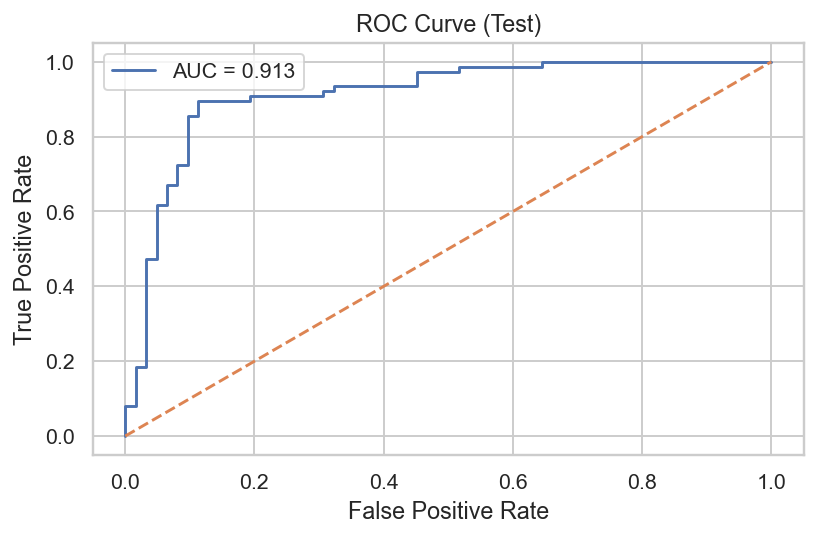

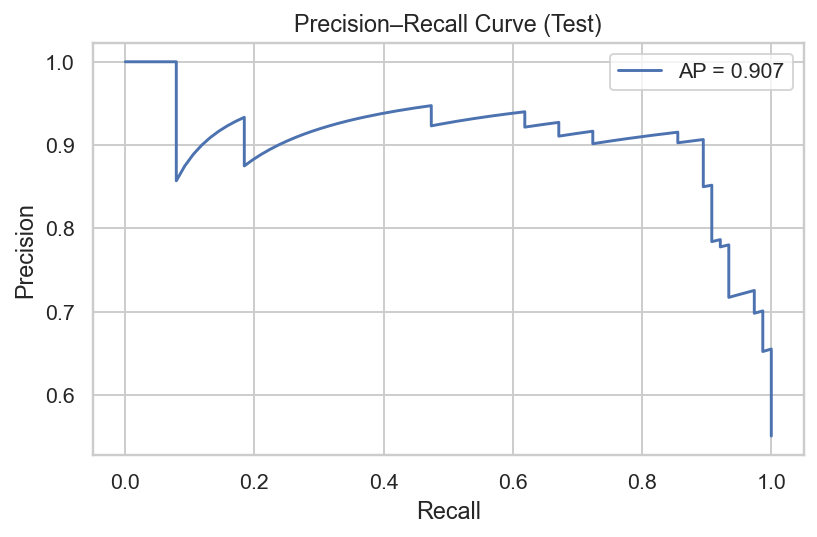

In [77]:
# =========================
# Test evaluation & plots
# =========================
# 1) Load best checkpoint
best_path = os.path.join(MODEL_PATH, "tabular_mlp.pt")
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(device).eval()
    print(f"Loaded best checkpoint from: {best_path}")
else:
    model.eval()
    print("Best checkpoint not found; evaluating current model in memory.")

# 2) Evaluate on the test set (loss + metrics)
test_metrics = evaluate(model, test_loader, criterion, device)
print(
    f"TEST | "
    f"loss={test_metrics['loss']:.4f} | "
    f"auc={test_metrics['auc']:.4f} | "
    f"ap={test_metrics['ap']:.4f} | "
    f"acc={test_metrics['acc']:.4f} | "
    f"f1={test_metrics['f1']:.4f}"
)

# 3) Get probabilities and targets for detailed analysis
@torch.no_grad()
def get_probs_and_targets(model, loader, device):
    model.eval()
    all_probs, all_targets = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float().unsqueeze(1)
        logits = model(xb)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.squeeze(1).cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_targets)

test_probs, test_y = get_probs_and_targets(model, test_loader, device)

# 4) Confusion matrix at threshold 0.5
thr = 0.5
test_pred = (test_probs >= thr).astype(int)
cm = confusion_matrix(test_y, test_pred, labels=[0, 1])  # rows=true, cols=pred
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix @0.5 (rows=true, cols=pred)")
print(cm)
print(f"TN={tn}  FP={fp}  FN={fn}  TP={tp}")

print("\nClassification report @0.5")
print(classification_report(test_y, test_pred, digits=4))

# 5) ROC and PR curves
fpr, tpr, _ = roc_curve(test_y, test_probs)
prec, rec, _ = precision_recall_curve(test_y, test_probs)

# ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_metrics['auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall curve
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"AP = {test_metrics['ap']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()